In [1]:
from numpy.random import seed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import itertools
import tensorflow
import tensorflow.keras
from tensorflow.keras.applications import ResNet152, Xception,VGG16,EfficientNetB4
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from keras.layers import BatchNormalization
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
np.random.seed(123)

In [2]:
dataset = '../input/weather-dataset/dataset/'
labels = sorted(os.listdir(dataset))
image = []
label = []
for i in labels:
    st = dataset + i
    for j in os.listdir(st):
        stg = st +"/"+ j
        label.append(i)
        image.append(stg)
        
WeatherData = pd.DataFrame({'label':label, 'path' : image}, columns = ['label', 'path'])

In [3]:
# print(WeatherData)
print(WeatherData['label'].value_counts())

rime         1160
fogsmog       851
dew           698
sandstorm     692
glaze         639
snow          621
hail          591
rain          526
frost         475
lightning     377
rainbow       232
Name: label, dtype: int64


In [4]:
WeatherData = WeatherData.sample(frac=1, random_state=42)

In [5]:
WeatherData['image'] = WeatherData['path'].map(lambda x: np.asarray(Image.open(x).resize((120,120), Image.LANCZOS).convert('RGB')))

In [6]:
print(WeatherData['label'].value_counts())

rime         1160
fogsmog       851
dew           698
sandstorm     692
glaze         639
snow          621
hail          591
rain          526
frost         475
lightning     377
rainbow       232
Name: label, dtype: int64


In [7]:
Features = np.stack(WeatherData['image'].values)
Target = WeatherData['label']

In [8]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.3,random_state=666)
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [9]:
label_encoder = LabelEncoder()
y_train_o = label_encoder.fit_transform(y_train_o)
y_test_o = label_encoder.transform(y_test_o)
y_train = to_categorical(y_train_o, num_classes = 11)
y_test = to_categorical(y_test_o, num_classes = 11)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 999, stratify=y_train)

In [10]:
input_shape = (120, 120, 3)
num_classes= 11

In [11]:
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], *input_shape)
print(x_train.shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)
x_validate = x_validate.reshape(x_validate.shape[0], *input_shape)


(3842, 120, 120, 3)
(3842, 120, 120, 3)


In [12]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in vgg_model.layers:
    layer.trainable = False

x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=x)

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

#Data Generation
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train,y_train, batch_size=256),
                              epochs = 50, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 256
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
15/15 [==============================] - 27s 1s/step - loss: 1.6960 - accuracy: 0.4414 - val_loss: 1.0932 - val_accuracy: 0.6597 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 14s 930ms/step - loss: 0.9452 - accuracy: 0.6905 - val_loss: 0.8815 - val_accuracy: 0.6951 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 13s 885ms/step - loss: 0.8165 - accuracy: 0.7214 - val_loss: 0.9321 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 14s 889ms/step - loss: 0.8689 - accuracy: 0.7038 - val_loss: 0.7318 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 13s 891ms/step - loss: 0.7615 - accuracy: 0.7409 - val_loss: 0.7603 - val_accuracy: 0.7357 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 13s 887ms/step - loss: 0.7041 - accuracy: 0.7566 - val_loss: 0.8138 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 7/50
15/15 [==============================] - 14s 920ms/step 

In [14]:
def Accuracies(model, x_train, x_validate, x_test, y_train, y_validate ,y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
    loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)
    print("Training: accuracy = %f" % (accuracy_t))
    print("Validation: accuracy = %f" % (accuracy_v))
    print("Test: accuracy = %f" % (accuracy))

In [15]:
Accuracies(model, x_train, x_validate, x_test, y_train, y_validate ,y_test)

Training: accuracy = 0.836804
Validation: accuracy = 0.749220
Test: accuracy = 0.790675


In [16]:
def ConfusionMatrix(model, x_test,y_test,label_encoder):
    predictions = np.array(list(map(lambda x: np.argmax(x), model.predict(x_test))))
    categories = label_encoder.classes_
    CM = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    CMatrix = pd.DataFrame(CM, columns = categories, index = categories)
    plt.figure(figsize=(12, 6)) 
    ax = sns.heatmap(CMatrix, annot = True, fmt = 'g',vmax = min(np.diagonal(CM)),cmap = 'ocean_r') 
    ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold') 
    ax.set_xticklabels(ax.get_xticklabels(),rotation =90); 
    ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
    ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
    plt.show()

65/65 [==============================] - 2s 21ms/step


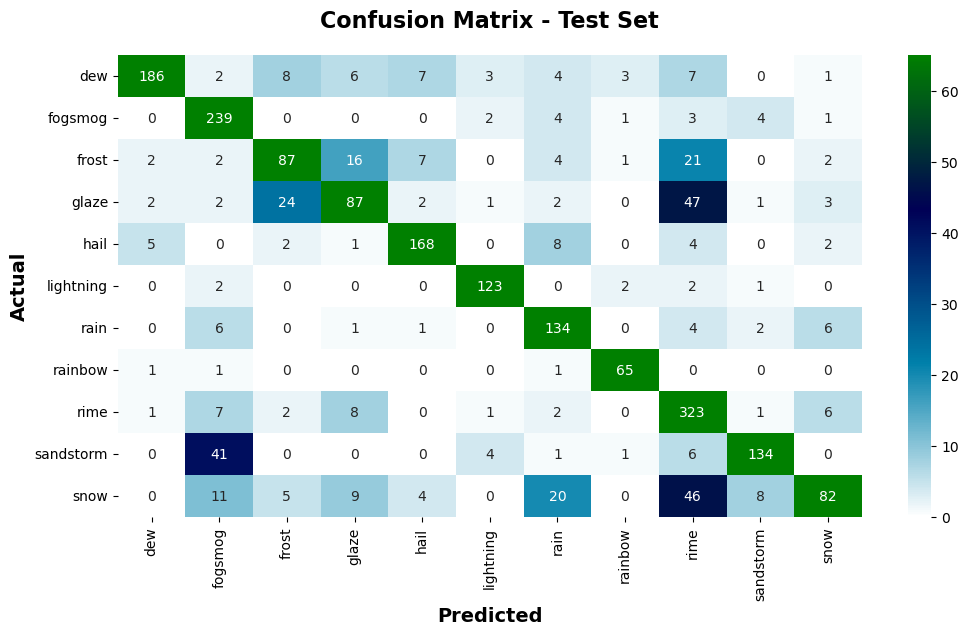

In [17]:
ConfusionMatrix(model, x_test, y_test, label_encoder)

In [18]:
y_test_pred = model.predict(x_test)
y_pred_orig = y_test
print(y_pred_orig.shape)

65/65 [==============================] - 1s 21ms/step
(2059, 11)


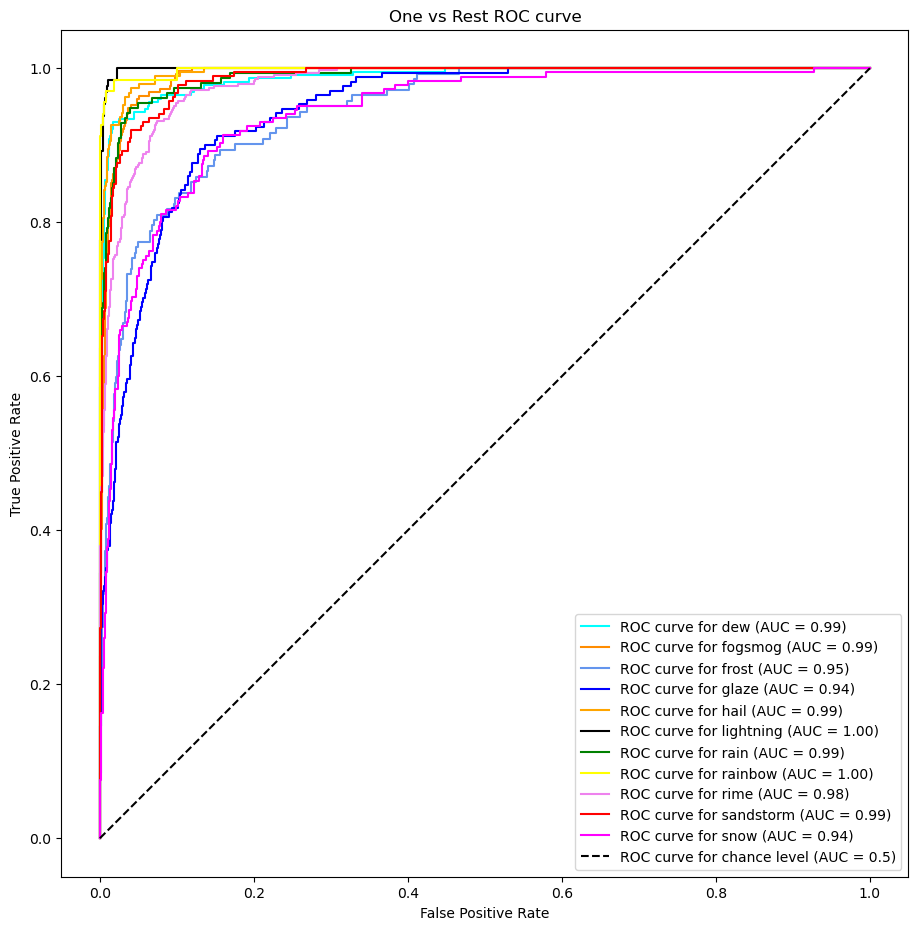

In [19]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(11, 11))
colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue", "orange", "black", "green", "yellow", "violet", "red", "magenta"])
for class_id, className in enumerate(label_encoder.classes_):
    RocCurveDisplay.from_predictions(
        y_pred_orig[:, class_id],
        y_test_pred[:, class_id],
        name=f"ROC curve for {className}",
        color=next(colors),
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One vs Rest ROC curve")
plt.legend()
plt.show()